# Informe Tecnico - Examen Transversal

Integrantes:


*   Benjamin Perez
*   Martin Pero
*   Esteban Maino

Docente: Italo Andrés Navarro Herrera

Seccion: MLY0100-004D





##Contexto del caso

Valve, los ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.


El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  


Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { Dato } & \text { Descripción } \\
\hline Map & \text {Nombre  del Mapa donde se jugó la partida}  \\
\hline \text{ Team} & \text { Nombre de equipo al que pertenece el jugador} \\
\hline \text{ InternalTeamId} & \text { Identificador del equipo al que pertenece el jugador.} \\
\hline \text{ MatchId} & \text { Identificador de la partida.} \\
\hline \text{ RoundId} & \text { Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas)} \\
\hline \text{ MatchWinner} & \text { Indica si el jugador ganó o no la partida.} \\
\hline \text{ RoundWinner} & \text { Indica si el jugador ganó o no la ronda analizada.} \\
\hline \text{ Survived} & \text { Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar).} \\
\hline \text{ AbnormalMatch} & \text { Indica si la partida del jugador tuvo un error por conexión de red} \\
\hline \text{ TimeAlive} & \text { Indica el tiempo en segundos que el jugador estuvo vivo durante el juego} \\
\hline \text{ TravelledDistance} & \text { Distancia viajada por el jugador durante la partida.} \\
\hline \text{ RLethalGrenadesThrown/RNonLethalGrenadesThrown} & \text { Cantidad de granadas lanzadas, categorizadas en letales y no-letales.} \\
\hline \text{ PrimaryXXXX} & \text { Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol.} \\
\hline \text{ [Match|Round] Assists} & \text { Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] Kills} & \text { Cantidad de kills efectuados por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] FlankKills} & \text { Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda.} \\
\hline \text{ [Match|Round] HeadShots} & \text { Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda.} \\
\hline \text{ RoundStartingEquipmentValue} & \text { Valor del equipamiento llevado por el jugador al inicio de la ronda.} \\
\hline \text{ TeamStartingEquipmentValue} & \text { Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda.} \\
\end{array}
\end{aligned}
$$

## Imports

In [ ]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

def cargar_dataset():
    # Ruta del archivo CSV local
    file_path = 'Anexo_ET_round_traces_2022.csv'

    # Cargar el CSV
    counter = pd.read_csv(file_path, sep=';')

    # Eliminar duplicados
    counter = counter.drop_duplicates()

    return counter

# Usar la función
counter = cargar_dataset()


In [ ]:
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#    name=fn
#counter = pd.read_csv(name, sep=";")

# Contenido de la primera evaluación

## Elementos Básicos de Estadística Descriptiva

### Resumen estadistico

Devuelve datos como la media, desviación estándar, mínimo y máximo

In [ ]:
def resumen_estadistico(counter):
    return counter.describe()

print(resumen_estadistico(counter));

          Unnamed: 0  InternalTeamId       MatchId       RoundId  \
count   79154.000000    79154.000000  79154.000000  79154.000000   
mean    60572.362812        1.499987    250.533959     12.765571   
std     36435.581528        0.500003    149.553596      7.432574   
min       600.000000        1.000000      4.000000      1.000000   
25%     30832.250000        1.000000    128.000000      6.000000   
50%     56721.500000        1.000000    236.000000     12.000000   
75%     90639.750000        2.000000    373.000000     19.000000   
max    123779.000000        2.000000    511.000000     36.000000   

       RLethalGrenadesThrown  RNonLethalGrenadesThrown  PrimaryAssaultRifle  \
count           79154.000000              79154.000000         79154.000000   
mean                0.498686                  1.258104             0.675351   
std                 0.597989                  1.184906             0.464130   
min                 0.000000                  0.000000             0.00

### Frecuencia absoluta

In [ ]:
def frecuencia_categoricas(counter):
    cat_cols = counter.select_dtypes(include=['object', 'category', 'bool']).columns
    return {col: counter[col].value_counts() for col in cat_cols}

frecuencias = frecuencia_categoricas(counter)
for col, freq in frecuencias.items():
    print(f'\nFrecuencia de "{col}":\n{freq}')



Frecuencia de "Map":
Map
de_inferno    28867
de_dust2      19120
de_mirage     19018
de_nuke       12149
Name: count, dtype: int64

Frecuencia de "Team":
Team
Terrorist           39590
CounterTerrorist    39562
Name: count, dtype: int64

Frecuencia de "RoundWinner":
RoundWinner
False    39587
True     39567
Name: count, dtype: int64

Frecuencia de "MatchWinner":
MatchWinner
False    42016
True     37138
Name: count, dtype: int64

Frecuencia de "Survived":
Survived
False    47214
True     31940
Name: count, dtype: int64

Frecuencia de "AbnormalMatch":
AbnormalMatch
False    79154
Name: count, dtype: int64

Frecuencia de "TimeAlive":
TimeAlive
0.0                       68
11.705.200.531.763.400    18
5.253.111.593.673.390     16
12.002.488.027.912.900    14
7.891.010.923.367.280     14
                          ..
249.246.364.265.928        1
29.729.856.301.939.000     1
28.909.452.908.587.200     1
3.348.027.181.440.440      1
47.804.002.732.825.200     1
Name: count, Length: 51627, dt

Se puede ver cuantas veces se repite cada dato, como por ejemplo y lo que se ve: Cuantas veces se jugó en el mapa, equipo en el que quedó, frecuencia de victorias, y matchwinner.

### Conteo de nulos

In [ ]:
counter.isnull().sum()


Unnamed: 0                     0
Map                            0
Team                           2
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    0
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaWwryPistol                0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssists                   0
MatchHeadshots                 0
dtype: int

Aqui se puede ver cuantos datos nulos hay en la base de datos

### Distribucion de una variable

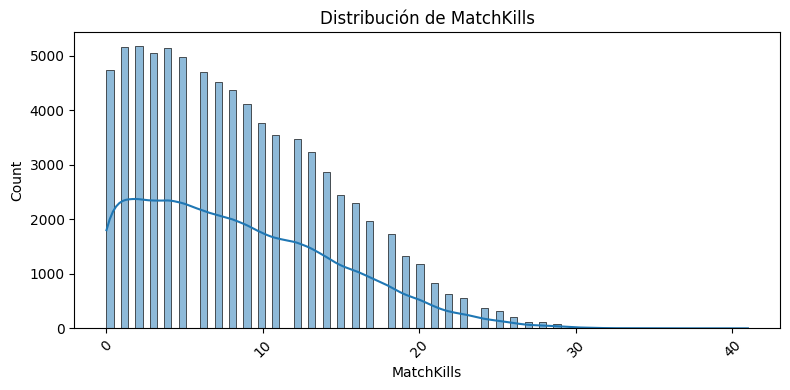

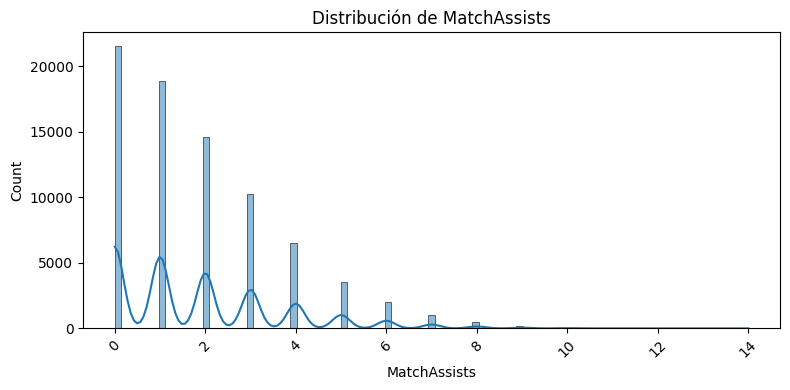

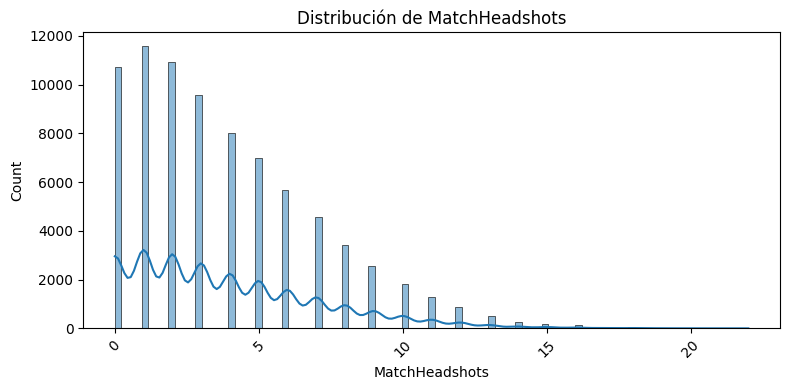

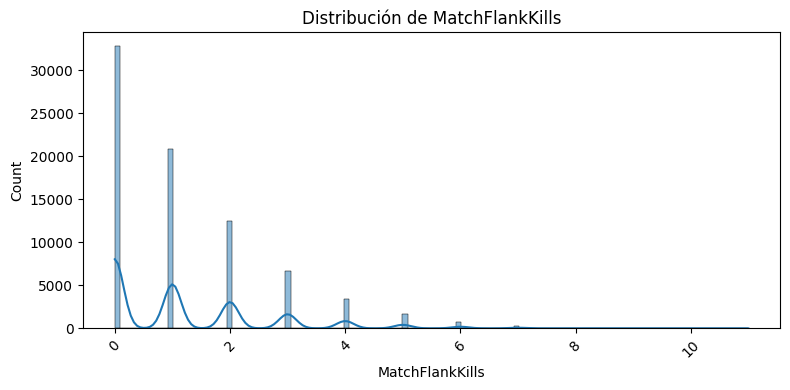

In [ ]:
def distribucion_variable(counter, columna):
    plt.figure(figsize=(8, 4))
    if pd.api.types.is_numeric_dtype(counter[columna]):
        sb.histplot(counter[columna], kde=True)
    else:
        sb.countplot(x=counter[columna])
    plt.title(f'Distribución de {columna}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Asumiendo que las columnas existen en tu DataFrame 'counter'
variables = ['MatchKills', 'MatchAssists', 'MatchHeadshots', 'MatchFlankKills']

for var in variables:
    distribucion_variable(counter, var)

## Manipula datos mediante la aplicacion de conceptos y elementos de álgebra lineal para descubrir patrones de datos

### Obtiene coeficiente de correlación por si solo entre las caracteristicas o bien la matriz de correlacion de Pearson

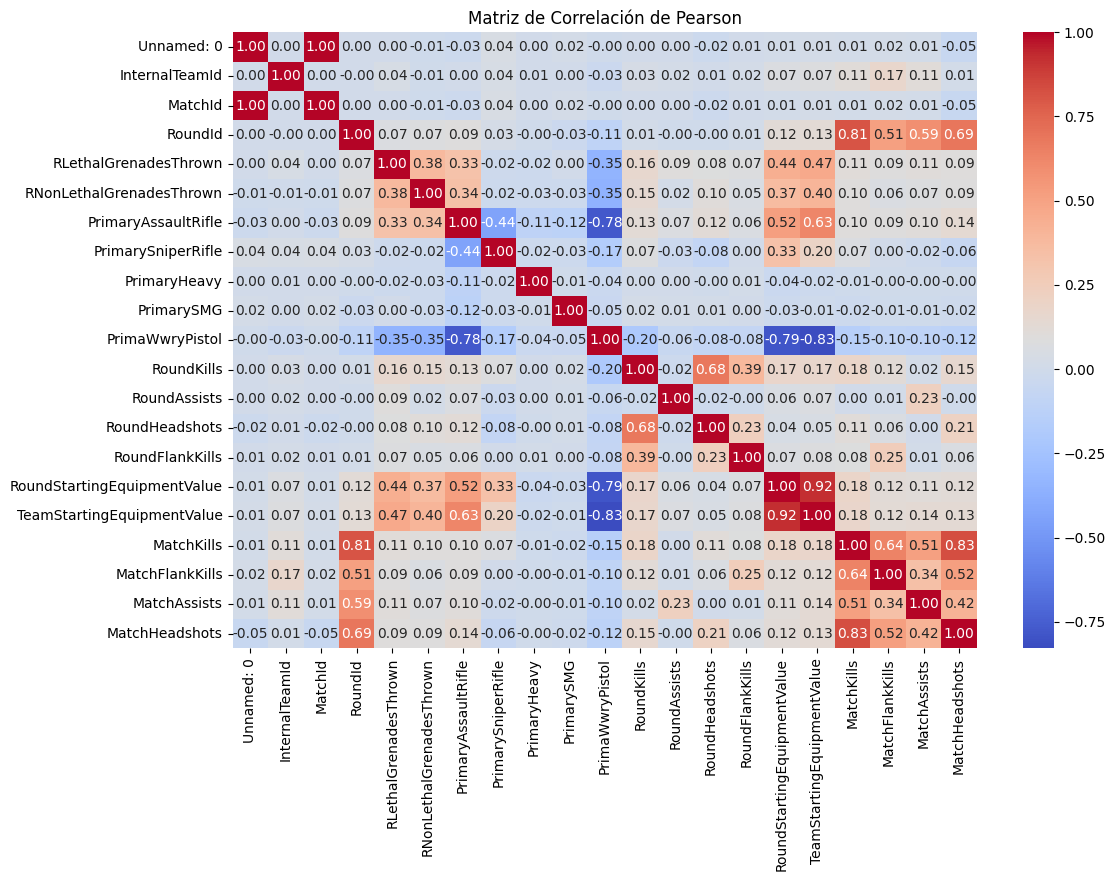

In [ ]:
# Selecciona solo las columnas numéricas
numericas = counter.select_dtypes(include=[np.number])

# Calcula la matriz de correlación de Pearson
matriz_correlacion = numericas.corr(method='pearson')

# Visualiza la matriz con un heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Pearson')
plt.show()

Se puede ver en este grafico que las relaciones con correlación más fuerte son:<br> <br> MatchKills con MatchHeadshots, MatchAssists, MatchFlankKills y RoundKills<br> <br> Ademas de MatchAssists con MatchHeadshots.<br> <br> Tambien se pueden observar otras relaciones relevantes como TeamStartingEquipmentValue y RoundStartingEquipmentValue, PrimaryPistol y PrimarySniperRifle.

## Analiza el contexto a partir de los datos entregados utilizando KPI para hacer descubrimientos del negocio

### Con el uso de estadisticos obtiene KPI relevantes como cantidad de derrotas, cantidad de triunfos, cantidad de jugadores, promedio de tiempo en partida, etc.

C:\Users\goten\AppData\Local\Temp\ipykernel_13888\1662149283.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=kpi_mapa, x='Map', y='SumaPromediosMatchKills', palette='viridis')


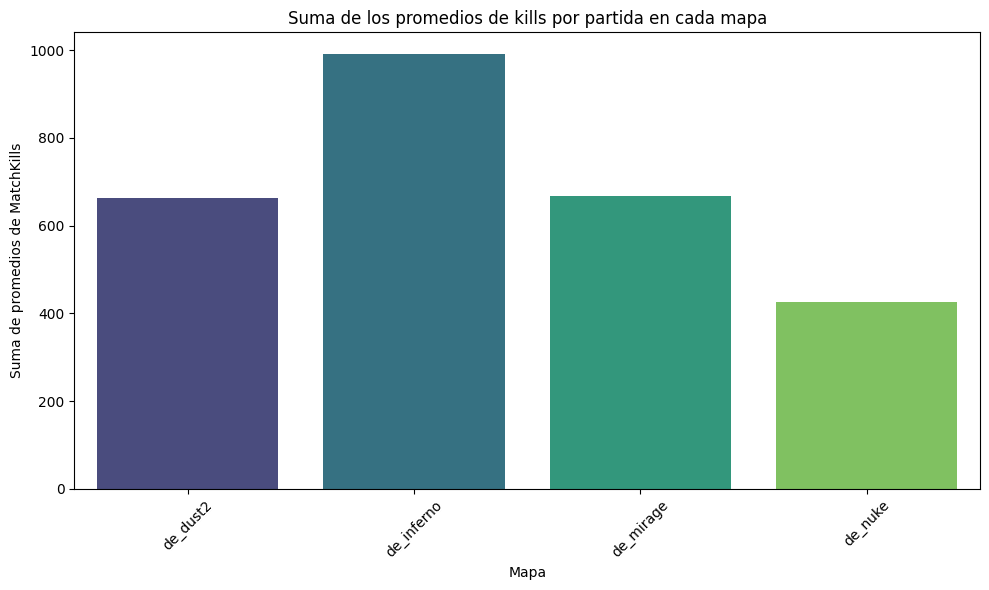

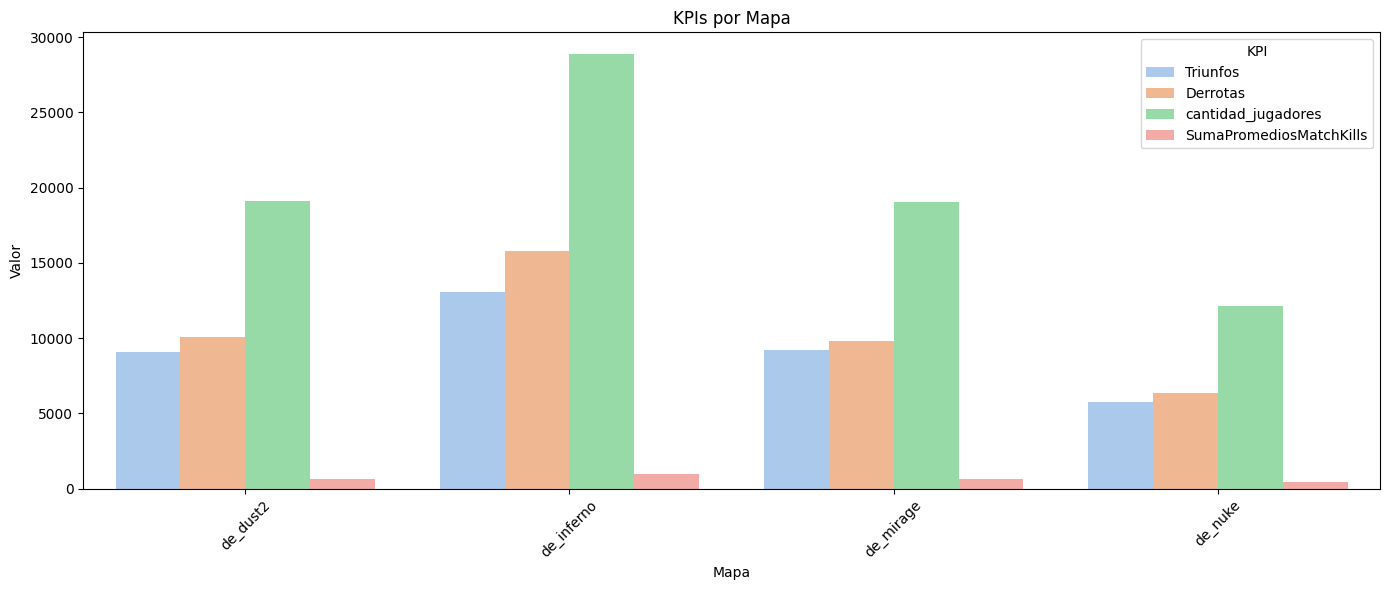

In [ ]:
# Asegurar tipos correctos para columnas booleanas
counter['MatchWinner'] = counter['MatchWinner'].astype(bool)
counter['RoundWinner'] = counter['RoundWinner'].astype(bool)

# Primero, calcula el promedio de kills por partida en cada mapa
promedios_por_partida = counter.groupby(['Map', 'MatchId'])['MatchKills'].mean().reset_index()

# Luego, suma esos promedios por cada mapa
suma_promedios = promedios_por_partida.groupby('Map')['MatchKills'].sum().reset_index()
suma_promedios = suma_promedios.rename(columns={'MatchKills': 'SumaPromediosMatchKills'})

# Si quieres agregarlo a tu KPI general:
kpi_mapa = counter.groupby('Map').agg(
    Triunfos=('MatchWinner', 'sum'),
    Derrotas=('MatchWinner', lambda x: (~x).sum()),
    cantidad_jugadores=('MatchWinner', 'size')
).reset_index()

# Unir ambos DataFrames
kpi_mapa = kpi_mapa.merge(suma_promedios, on='Map', how='left')

plt.figure(figsize=(10, 6))
sb.barplot(data=kpi_mapa, x='Map', y='SumaPromediosMatchKills', palette='viridis')
plt.title('Suma de los promedios de kills por partida en cada mapa')
plt.ylabel('Suma de promedios de MatchKills')
plt.xlabel('Mapa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

kpi_mapa_largo = kpi_mapa.melt(id_vars='Map', var_name='KPI', value_name='Valor')

plt.figure(figsize=(14, 6))
sb.barplot(data=kpi_mapa_largo, x='Map', y='Valor', hue='KPI', palette='pastel')
plt.title('KPIs por Mapa')
plt.ylabel('Valor')
plt.xlabel('Mapa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Según los presentes graficos se puede notar que el numero de derrotas siempre es mas alto que el numero de victorias, tambien que el mapa mas popular es Inferno.

## Diferencia los tipos de datos considerando la naturaleza de las variables involucradas en una problematica dada

### Identifica cuando el dato es numérico continuo, discreto, o variable categórica nominal u ordinal.

In [ ]:
for col in sorted(counter.columns):
    print(col)

AbnormalMatch
FirstKillTime
InternalTeamId
Map
MatchAssists
MatchFlankKills
MatchHeadshots
MatchId
MatchKills
MatchWinner
PrimaWwryPistol
PrimaryAssaultRifle
PrimaryHeavy
PrimarySMG
PrimarySniperRifle
RLethalGrenadesThrown
RNonLethalGrenadesThrown
RoundAssists
RoundFlankKills
RoundHeadshots
RoundId
RoundKills
RoundStartingEquipmentValue
RoundWinner
Survived
Team
TeamStartingEquipmentValue
TimeAlive
TravelledDistance
Unnamed: 0


#### Identificadores <br> Unnamed: Índice de fila (numero discreto) <br> InternalTeamId: ID interno del equipo (numerico discreto) <br> MatchId: ID de la partida (numerico discreto) <br> RoundId: ID de la ronda (numerico discreto)

#### Contexto de la partida <br> Map: Nombre del mapa (Categorica nominal) <br> Team: Tipo de equipo (Categorica nominal) <br> AbnormalMatch: Indica si la partida fue anormal (booleano)

#### Resultado de partida y ronda <br> RoundWinner: El equipo ganó la ronda (booleano). <br> MatchWinner: El equipo ganó la partida(booleano)

#### Estado del jugador <br> Survived: El jugador sobrevivió la ronda (booleano) <br> TimeAlive: Tiempo vivo en la ronda (numérico continuo, posiblemente requiere limpieza). <br> TravelledDistance: Distancia recorrida en la ronda (numérico continuo, posiblemente a limpiar).

#### Acciones por ronda <br> RLethalGrendadesThrown: Granadas letales lanzadas (numérico discreto). <br> RNonLethalGrenadesThrown: Granadas no letales lanzadas (numérico discreto). <br> FirstKillTime: Tiempo del primer kill (numérico continuo). <br> RoundKills: Kills realizados en la ronda (numérico discreto). <br> RoundAssists: Asistencias realizadas en la ronda (numérico discreto). <br> RoundHeadshots: Headshots en la ronda (numérico discreto). <br> RoundFlankKills: Flanqueos exitosos en la ronda (numérico discreto).

#### Armas utilizadas <br> PrimaryAssaultRifle: Uso de rifle de asalto (discreto o binario).<br> PrimarySniperRifle: Uso de rifle francotirador (discreto/binario).<br> PrimaryHeavy: Uso de arma pesada (discreto o binario).<br> PrimarySMG: Uso de subfusil (discreto o binario). <br> PrimaryPistol: Uso de pistola (discreto o binario).



#### Economia <br>RoundStartingEquipmentValue: Valor del equipo al inicio de la ronda (numérico discreto). <br> TeamStartingEquipmentValue: Valor del equipo completo al inicio de la ronda (numerico discreto).

#### Totales por partida <br> MatchKills:	Total de kills en la partida (numérico discreto). <br> MatchAssists	Total de asistencias en la partida (numérico discreto).<br> MatchFlankKills	Total de kills por flanqueo en la partida (discreto).<br> MatchHeadshots	Total de headshots en la partida (numérico discreto).

## Evalúa la relevancia de los datos de un problema, verificando aquellos datos faltantes y seleccionando herramientas estadísticas y gráficas para realizar acciones de limpieza y transformación mediante el uso de Python

### Trabaja los missing values (valores NaN) y los datos outliers, considerando las mejores prácticas con respecto al uso de los datos

In [ ]:
# Ver cantidad de valores faltantes por columna
print(counter.isnull().sum())

# Visualizar porcentaje de valores faltantes
print((counter.isnull().mean() * 100).sort_values(ascending=False))

Unnamed: 0                     0
Map                            0
Team                           2
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    0
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaWwryPistol                0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssists                   0
MatchHeadshots                 0
dtype: int

In [ ]:
#Limpieza de datos faltantes
counter = counter.dropna(thresh=counter.shape[1] - 2)  # Permite hasta 2 NaN por fila

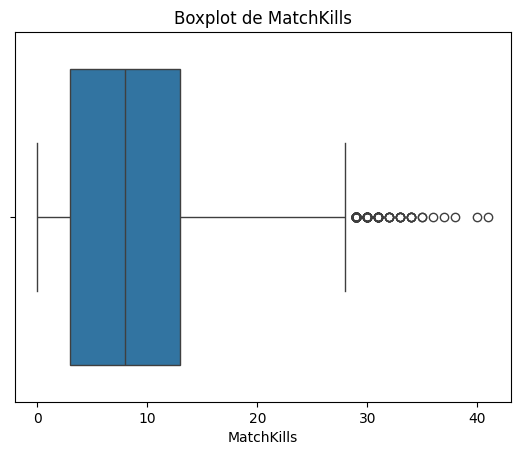

In [ ]:
#Detección y tratamiento de outliers
# Visualizar outliers en una variable numérica
sb.boxplot(x=counter['MatchKills'])
plt.title('Boxplot de MatchKills')
plt.show()

# Eliminar outliers usando el rango intercuartílico (IQR)
Q1 = counter['MatchKills'].quantile(0.25)
Q3 = counter['MatchKills'].quantile(0.75)
IQR = Q3 - Q1
filtro = (counter['MatchKills'] >= Q1 - 1.5 * IQR) & (counter['MatchKills'] <= Q3 + 1.5 * IQR)
counter = counter[filtro]

Despues de ejecutar este codigo se puede ver que los outliers desaparecieron, los cuales marcaban sobre 20 kills

#### Herramientas estadisticas y graficas recomendadas

In [ ]:
#Resumen estadístico después de limpieza
print(counter.describe())

          Unnamed: 0  InternalTeamId       MatchId       RoundId  \
count   78992.000000    78992.000000  78992.000000  78992.000000   
mean    60554.791789        1.499886    250.462439     12.739151   
std     36439.638171        0.500003    149.570759      7.415599   
min       600.000000        1.000000      4.000000      1.000000   
25%     30805.750000        1.000000    128.000000      6.000000   
50%     56709.500000        1.000000    236.000000     12.000000   
75%     90633.250000        2.000000    373.000000     18.000000   
max    123779.000000        2.000000    511.000000     36.000000   

       RLethalGrenadesThrown  RNonLethalGrenadesThrown  PrimaryAssaultRifle  \
count           78992.000000              78992.000000         78992.000000   
mean                0.498582                  1.257558             0.675382   
std                 0.597982                  1.184871             0.464121   
min                 0.000000                  0.000000             0.00

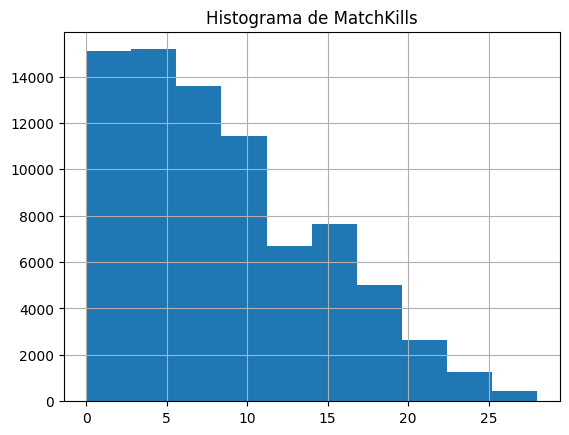

In [ ]:
counter['MatchKills'].hist()
plt.title('Histograma de MatchKills')
plt.show()

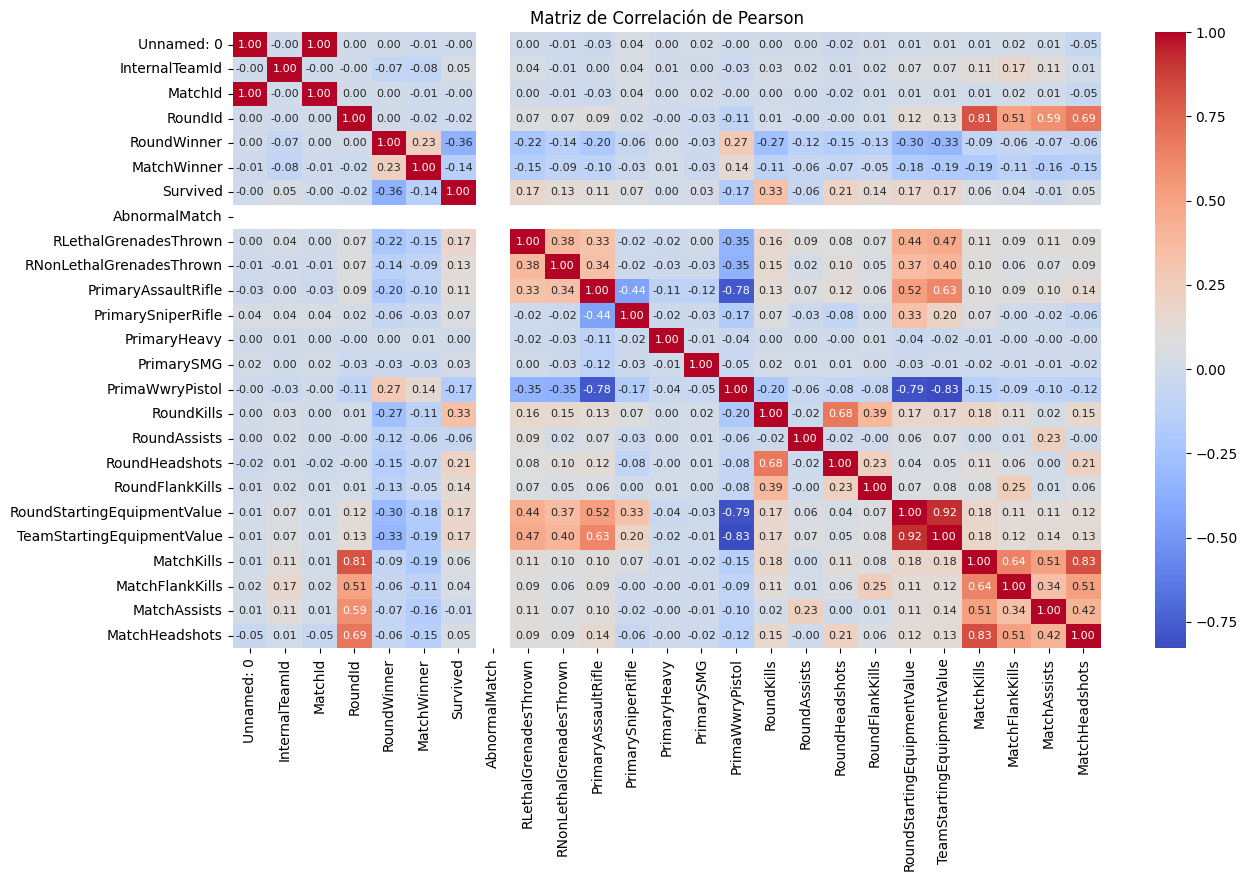

In [ ]:
plt.figure(figsize=(14, 8))
sb.heatmap(
    counter.corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    annot_kws={"size": 8}  # Tamaño más pequeño para los números
)
plt.title('Matriz de Correlación de Pearson')
plt.show()

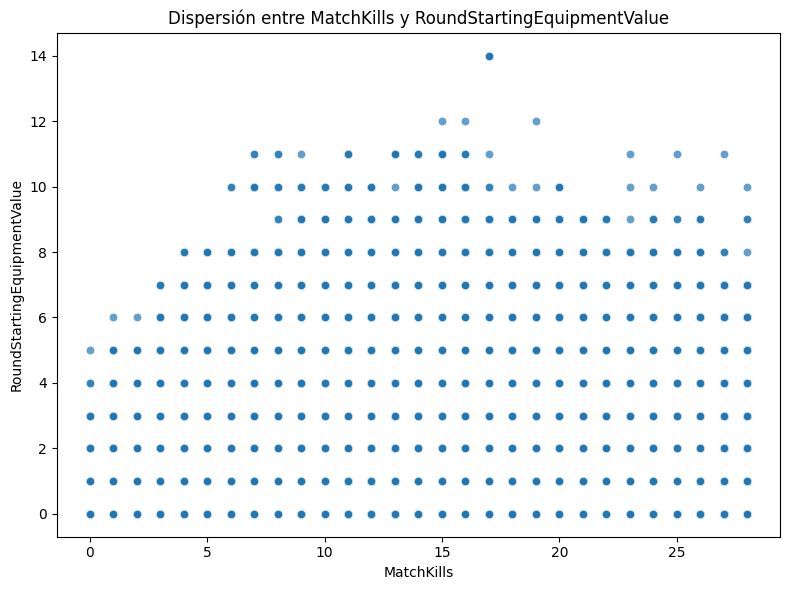

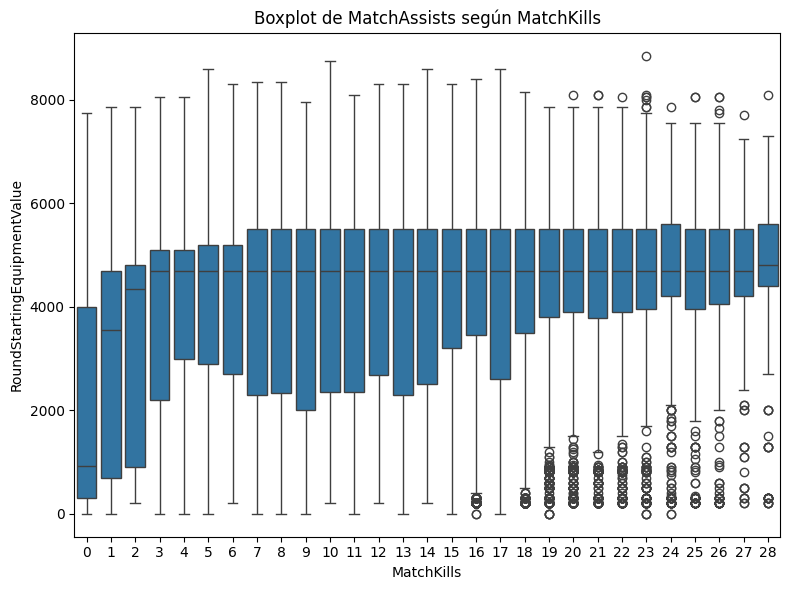

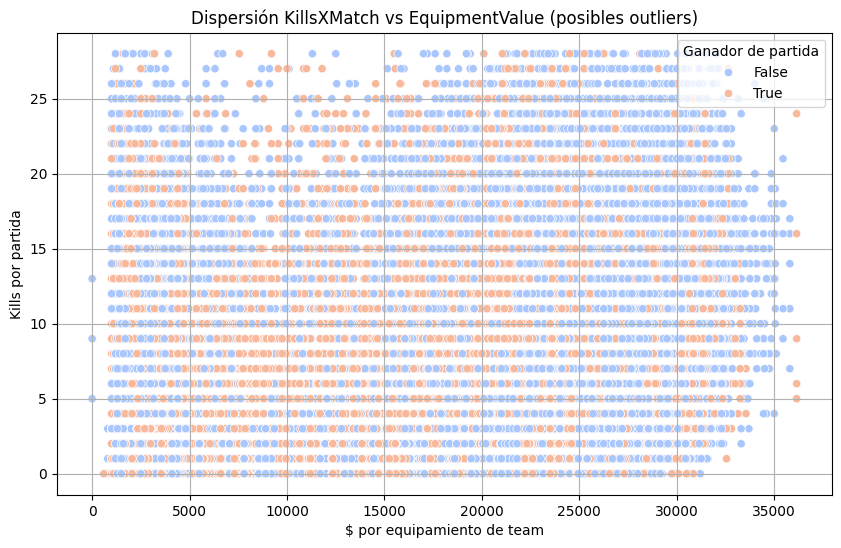

In [ ]:
plt.figure(figsize=(8, 6))
sb.scatterplot(data=counter, x='MatchKills', y='MatchAssists', alpha=0.7)
plt.title('Dispersión entre MatchKills y RoundStartingEquipmentValue')
plt.xlabel('MatchKills')
plt.ylabel('RoundStartingEquipmentValue')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sb.boxplot(data=counter, x='MatchKills', y='RoundStartingEquipmentValue')
plt.title('Boxplot de MatchAssists según MatchKills')
plt.xlabel('MatchKills')
plt.ylabel('RoundStartingEquipmentValue')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sb.scatterplot(data=counter, x='TeamStartingEquipmentValue', y='MatchKills', hue='MatchWinner', palette='coolwarm')

plt.title('Dispersión KillsXMatch vs EquipmentValue (posibles outliers)')
plt.xlabel('$ por equipamiento de team')
plt.ylabel('Kills por partida')
plt.legend(title='Ganador de partida')
plt.grid(True)
plt.show()


## Identifica si los datos son apropiados para el modelo, según el orden de magnitud presente, seleccionando la rutina de Python adecuada para estandarizarlos.

### Utiliza técnicas de transformación de datos adecuada de acuerdo a la naturaleza de estos.

### Utiliza las técnicas de transformación necesarias, ya sea de scaling, normalización o encoding para dejar listos los datos para la fase de Modeling.

In [ ]:
print(counter.describe())

          Unnamed: 0  InternalTeamId       MatchId       RoundId  \
count   78992.000000    78992.000000  78992.000000  78992.000000   
mean    60554.791789        1.499886    250.462439     12.739151   
std     36439.638171        0.500003    149.570759      7.415599   
min       600.000000        1.000000      4.000000      1.000000   
25%     30805.750000        1.000000    128.000000      6.000000   
50%     56709.500000        1.000000    236.000000     12.000000   
75%     90633.250000        2.000000    373.000000     18.000000   
max    123779.000000        2.000000    511.000000     36.000000   

       RLethalGrenadesThrown  RNonLethalGrenadesThrown  PrimaryAssaultRifle  \
count           78992.000000              78992.000000         78992.000000   
mean                0.498582                  1.257558             0.675382   
std                 0.597982                  1.184871             0.464121   
min                 0.000000                  0.000000             0.00

#### Estandarizacion (Standard Scaling) y normalizacion <br> Estandarizacion: Centra los datos en media 0  y desviación estándar 1 <br> Normalización: Escala los datos entre 0 y 1

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Selecciona solo las columnas numéricas relevantes
columnas_numericas = ['MatchKills', 'MatchAssists', 'MatchHeadshots', 'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue']

# Estandarización
scaler = StandardScaler()
counter[columnas_numericas] = scaler.fit_transform(counter[columnas_numericas])

# O, si prefieres normalización:
# scaler = MinMaxScaler()
# counter[columnas_numericas] = scaler.fit_transform(counter[columnas_numericas])

#### Encoding para variables categoricas

In [ ]:
counter = pd.get_dummies(counter, columns=['Map', 'Team'], drop_first=True)

Esta funcion convierte las columnas categoricas Map y Team con valores 0 y 1 indicando la presencia de esa categoria en cada fila

In [ ]:
print([col for col in counter.columns if 'Map_' in col or 'Team_' in col])
print(counter.head())

['Map_de_inferno', 'Map_de_mirage', 'Map_de_nuke', 'Team_Terrorist']
   Unnamed: 0  InternalTeamId  MatchId  RoundId  RoundWinner  MatchWinner  \
0         600               1        4        1        False         True   
1         601               1        4        1        False         True   
2         602               1        4        1        False         True   
3         603               1        4        1        False         True   
4         604               1        4        1        False         True   

   Survived  AbnormalMatch               TimeAlive       TravelledDistance  \
0     False          False  51.120.248.995.704.500  10.083.140.737.457.000   
1     False          False   4.348.662.552.266.170  60.960.883.184.688.400   
2     False          False   3.735.469.847.054.540   5.642.252.383.582.750   
3     False          False   4.767.886.136.441.470   8.963.473.313.229.970   
4      True          False   5.312.251.089.027.310  10.865.649.734.393.100   


# Contenido de la segunda evaluación

## Modelos de regresion

### Comprende las bases de Machine Learning, sus metodologías, herramientas y técnicas asociadas a las diferentes formas de aprendizaje automático.

### IL3.1 Comprende las bases de Machine Learning y la metodología CRISP-DM

La metodología **CRISP-DM** (Cross Industry Standard Process for Data Mining) es un estándar ampliamente utilizado para proyectos de análisis de datos y Machine Learning. Sus fases son:

1. **Comprensión del negocio:**  
   Entender los objetivos y requisitos del proyecto desde una perspectiva de negocio.  
   *En este caso, el objetivo es analizar y predecir resultados en partidas de Counter Strike: GO para mejorar el rendimiento y la toma de decisiones.*

2. **Comprensión de los datos:**  
   Recopilar, describir y explorar los datos para familiarizarse con ellos y detectar problemas de calidad.  
   *Ya se realizó la exploración, limpieza y análisis descriptivo de los datos del juego.*

3. **Preparación de los datos:**  
   Seleccionar, limpiar y transformar los datos para el modelado.  
   *Se aplicaron técnicas de limpieza, tratamiento de outliers, escalado y codificación de variables categóricas.*

4. **Modelado:**  
   Seleccionar y aplicar técnicas de Machine Learning (regresión, clasificación, etc.) para construir modelos predictivos.  
   *En la siguiente sección se implementarán modelos de regresión y clasificación.*

5. **Evaluación:**  
   Evaluar los modelos generados y comprobar si cumplen los objetivos de negocio.  
   *Se utilizarán métricas como accuracy, precisión, recall, F1-score o RMSE según el tipo de modelo.*

6. **Despliegue:**  
   Implementar el modelo en un entorno real o entregar los resultados para la toma de decisiones.  
   *En este proyecto, los resultados se presentan en este informe técnico.*

---

**Herramientas y técnicas utilizadas:**  
- Python, pandas, numpy, matplotlib, seaborn  
- Scikit-learn para modelado y evaluación  
- Técnicas de regresión, clasificación y validación cruzada

---

Esta estructura asegura que el proyecto siga buenas prácticas y sea reproducible, claro y alineado con los objetivos del negocio.

### Fase de Modelado: Regresión

En esta sección se implementarán modelos de regresión para predecir una variable objetivo, siguiendo la metodología CRISP-DM:
1. Selección de algoritmo de regresión (e.g., LinearRegression).
2. División de los datos en entrenamiento y prueba.
3. Entrenamiento y evaluación con métricas (RMSE, R²).


In [ ]:
# Limpieza de columnas numéricas con separadores de miles y conversión a float
numeric_str_cols = ['TimeAlive', 'TravelledDistance', 'FirstKillTime',
                    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue']
for col in numeric_str_cols:
    # Eliminar separadores de miles
    counter[col] = counter[col].astype(str).str.replace('.', '', regex=False)
    # Convertir a numérico
    counter[col] = pd.to_numeric(counter[col], errors='coerce')
# Eliminar filas con NaN tras conversión
drop_na_before = counter.shape[0]
counter = counter.dropna(subset=numeric_str_cols)
print(f"Filas eliminadas tras limpieza: {drop_na_before - counter.shape[0]}")

Filas eliminadas tras limpieza: 0


### Modelo de regresion lineal

RMSE: 2.35
R²: 0.86


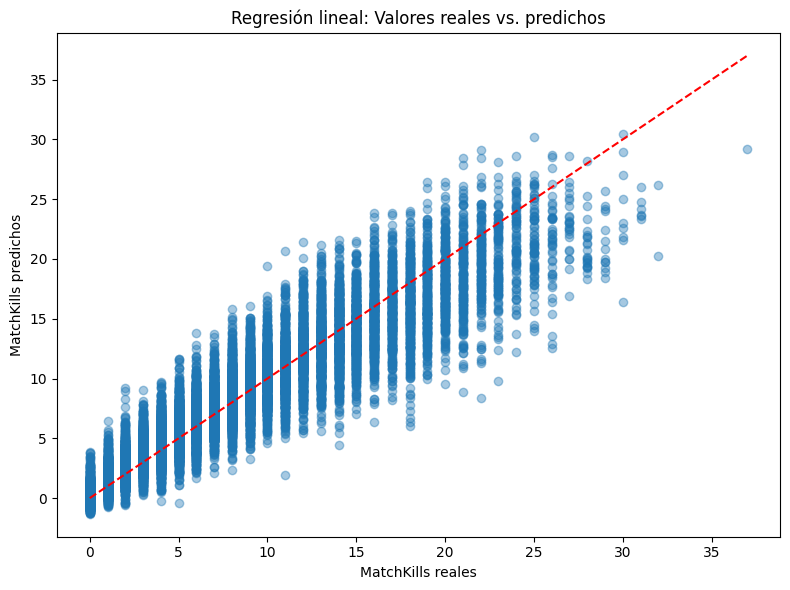

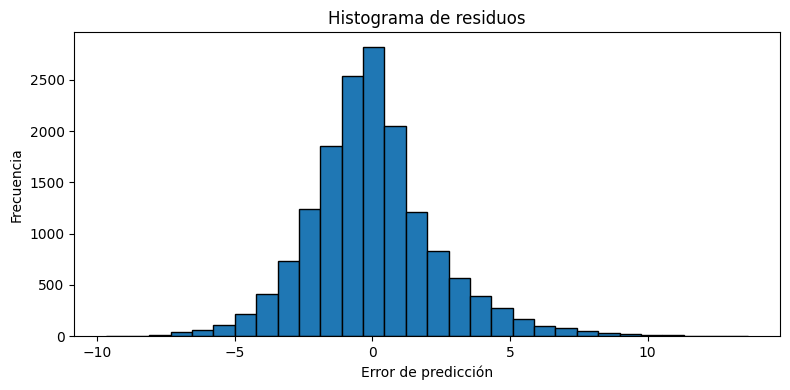

In [ ]:
# Definir variables predictoras (X) y objetivo (y)
target = 'MatchKills'
categorical_cols = ['Map', 'Team']
numeric_cols = counter.select_dtypes(include=[np.number, 'bool']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target]
X = counter[numeric_cols + categorical_cols]
y = counter[target]

# Codificar variables categóricas
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instanciar y entrenar regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predecir y evaluar
preds = lr.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2_score(y_test, preds):.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.4)
plt.xlabel('MatchKills reales')
plt.ylabel('MatchKills predichos')
plt.title('Regresión lineal: Valores reales vs. predichos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea ideal
plt.tight_layout()
plt.show()

residuos = y_test - preds
plt.figure(figsize=(8, 4))
plt.hist(residuos, bins=30, edgecolor='k')
plt.title('Histograma de residuos')
plt.xlabel('Error de predicción')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

En el codigo anterior se puede ver como se entrena un modelo de regresion lineal para predecir la variable MatchKills. <br> <br> Este modelo se evalúa con dos metricas RMSE, el cual indica que el modelo se equivoca en aproximadamente 2.35 kills al intentar predecir el valor real. <br> <br> R^2 (Coeficiente de determinacion) 0.86 Esto significa que el modelo explica el 86% de la varianza de la variable objetivo <br> <h4>Interpretación del grafico de dispersion</h4> Los puntos se agrupan cerca de la linea roja, lo que demuestra que el modelo predice muy bien gran parte de los casos. <h4>Interpretación del Histograma de residuos</h4> La mayoría de los residuos están cerca de 0, lo que indica que el modelo predice bien los casos.

### Modelo de regresión logistica con matriz de confusión

Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.64      0.55      0.59      7886
           1       0.61      0.70      0.65      7945

    accuracy                           0.62     15831
   macro avg       0.63      0.62      0.62     15831
weighted avg       0.63      0.62      0.62     15831



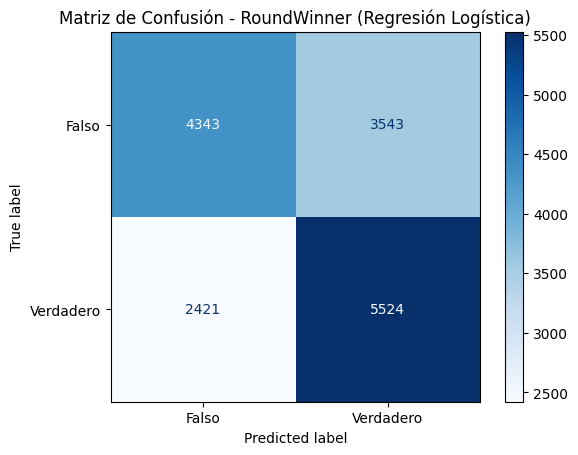

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Definir variables predictoras y objetivo
features = ['RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills']
X = counter[features]
y = counter['RoundWinner'].astype(int)  # Asegura que sea 0/1

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instanciar y entrenar regresión logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predecir y evaluar
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, display_labels=['Falso', 'Verdadero'], cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - RoundWinner (Regresión Logística)")
plt.show()

<h3> Que se puede inferir de los datos e imagen? <br>

<h4>1. Precisión general: </h4>El modelo tiene una precisión del 62%

<h4>2. Matriz de confusión: </h4>4343: Verdaderos negativos (predijo "Falso" y era "Falso").<br>
5524: Verdaderos positivos (predijo "Verdadero" y era "Verdadero"). <br>
3543: Falsos positivos (predijo "Verdadero" pero era "Falso"). <br>
2421: Falsos negativos (predijo "Falso" pero era "Verdadero"). <br>

### Modelo de regresión con Arbol de decisión

Árbol de Decisión - RMSE: 2.79
Árbol de Decisión - R²: 0.80


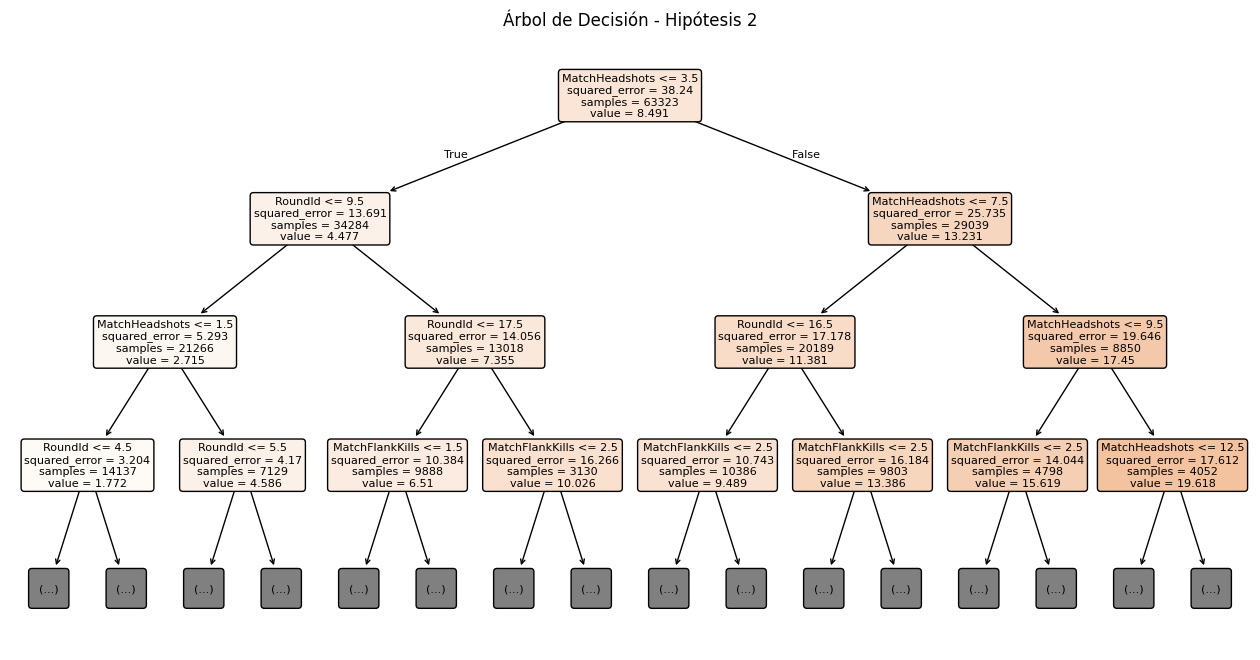

In [ ]:
# Definir variables predictoras (X) y objetivo (y)
target = 'MatchKills'
categorical_cols = ['Map', 'Team']
numeric_cols = counter.select_dtypes(include=[np.number, 'bool']).columns.tolist()
# Elimina 'MatchId' y asegura que 'MatchAssists' esté incluida
numeric_cols = [col for col in numeric_cols if col not in ['MatchId', target]]
if 'MatchAssists' not in numeric_cols:
    numeric_cols.append('MatchAssists')
X = counter[numeric_cols + categorical_cols]
y = counter[target]

# Codificar variables categóricas
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.tree import DecisionTreeRegressor

# Instanciar y entrenar el modelo de árbol de decisión
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Predecir y evaluar
tree_preds = tree.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_preds)
tree_rmse = np.sqrt(tree_mse)
print(f"Árbol de Decisión - RMSE: {tree_rmse:.2f}")
print(f"Árbol de Decisión - R²: {r2_score(y_test, tree_preds):.2f}")

from sklearn.tree import plot_tree

plt.figure(figsize=(16, 8))
plot_tree(
    tree,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=3,  # Puedes ajustar la profundidad para que sea más legible
)
plt.title("Árbol de Decisión - Hipótesis 2")
plt.show()

<h4>Capacidad predictiva del modelo</h4>
El modelo tiene un R^2 de 0.80, lo que significa que explica el 80% de la varianza de la variable objetivo (MatchKills) <br> El RMSE es 2.79, indicando que el error promedio de predicción es de aproximadamente 2.8 kills. <br> Cada nodo muestra el valor promedio de kills para ese grupo de jugadores, el error cuadrático medio y la cantidad de muestras. <br>
Por ejemplo, jugadores con pocos headshots y en rondas tempranas tienen menos kills en promedio.

### Modelo de regresión con supervector machine

Accuracy SVM: 0.63
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      7886
           1       0.64      0.60      0.62      7945

    accuracy                           0.63     15831
   macro avg       0.63      0.63      0.63     15831
weighted avg       0.63      0.63      0.63     15831



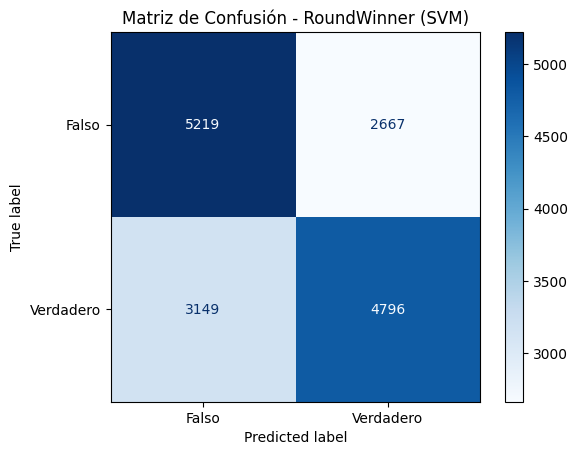

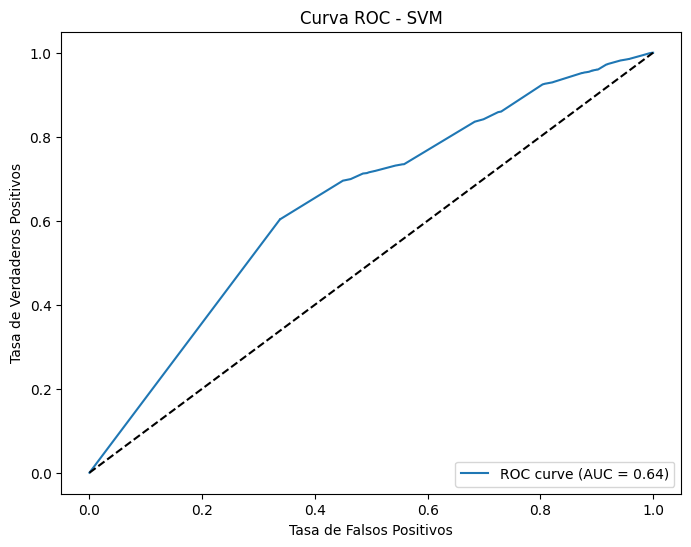

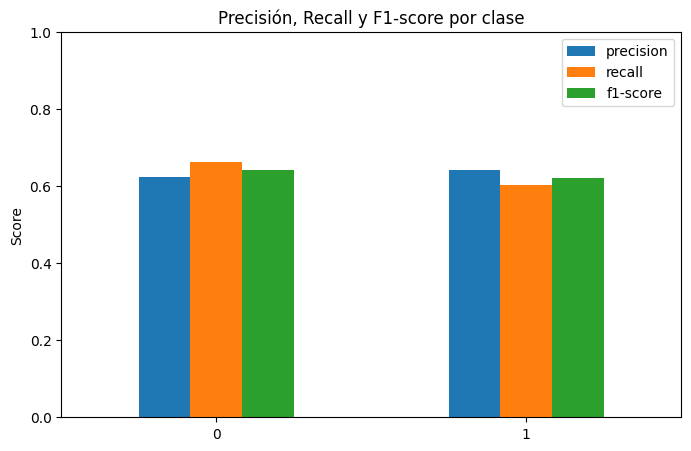

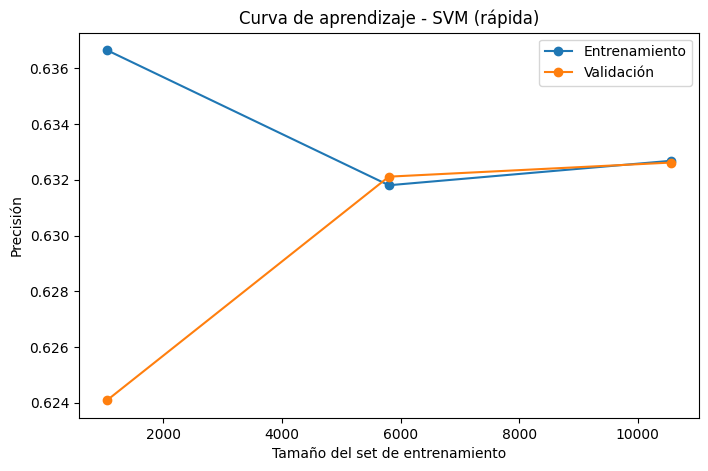

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay,
    roc_curve, auc
)
import seaborn as sns

# Definir variables predictoras y objetivo
features = ['RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills']
X = counter[features]
y = counter['RoundWinner'].astype(int)  # 0 o 1

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instanciar y entrenar SVM con probabilidades
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predecir y evaluar
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy SVM: {acc:.2f}")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, display_labels=['Falso', 'Verdadero'], cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - RoundWinner (SVM)")
plt.show()

# 1. Curva ROC y AUC
y_proba = svm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.show()

# 2. Reporte de clasificación como gráfico de barras
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:2, :3]  # Solo clases, no avg

df_report.plot(kind='bar', figsize=(8,5))
plt.title('Precisión, Recall y F1-score por clase')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

# 3. Curva de aprendizaje
from sklearn.model_selection import learning_curve
import numpy as np

# Usa solo una muestra del 20% de los datos para la curva de aprendizaje
X_sample = X.sample(frac=0.2, random_state=42)
y_sample = y.loc[X_sample.index]

# Reduce la cantidad de folds y puntos de entrenamiento
train_sizes, train_scores, test_scores = learning_curve(
    svm, X_sample, y_sample, cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 3)  # Solo 3 puntos
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', label='Validación')
plt.xlabel('Tamaño del set de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de aprendizaje - SVM (rápida)')
plt.legend()
plt.show()

<h3>Datos Inferidos</h3>
<h4>Grafico de confusión</h4>
¿Que significa cada valor?<br>Falso/Falso (5219):
El modelo predijo "Falso" (no ganó la ronda) y realmente no ganó la ronda.
→ Verdaderos negativos.<br>

Falso/Verdadero (2667):
El modelo predijo "Verdadero" (ganó la ronda) pero realmente no ganó la ronda.
→ Falsos positivos.<br>

Verdadero/Falso (3149):
El modelo predijo "Falso" pero realmente ganó la ronda.
→ Falsos negativos.<br>

Verdadero/Verdadero (4796):
El modelo predijo "Verdadero" y realmente ganó la ronda.
→ Verdaderos positivos.<br>

Interpretación general<br>El modelo acierta más veces de las que se equivoca, pero aún hay una cantidad considerable de errores.<br>

Precisión general:
La suma de los aciertos (5219 + 4796) es mayor que la de los errores (2667 + 3149).<br>

El modelo es un poco mejor prediciendo cuando un equipo no gana la ronda (5219) que cuando sí gana (4796).


<h4>Curva ROC</h4>
¿Que se puede inferir?<br>

El modelo Super Vector Machine tiene cierta capacidad para distinguir entre rondas ganadas y perdidas, pero no es muy alto (AUC=0.64).<br>Se recomienda ajustar el modelo o probar otras variables para mejorar el desempeño

<h4>Precision, Recall y F1 Score</h4>
¿Qué se puede inferir?
Clases:

0: No ganó la ronda
1: Ganó la ronda
Valores de las métricas:

Todas las métricas (precisión, recall y F1-score) están alrededor de 0.6 a 0.65 para ambas clases.
No hay una clase que tenga un desempeño mucho mejor que la otra.
Interpretación:

El modelo tiene un desempeño moderado y balanceado para ambas clases.
No hay un sesgo fuerte hacia una clase específica.
El modelo no es perfecto, pero tampoco es aleatorio: acierta en aproximadamente el 60-65% de los casos para ambas clases.

<h4>Curva de aprendizaje</h4>
¿Que se puede inferir?

Las curvas de entrenamiento y validación se acercan a medida que aumenta la cantidad de datos, lo que indica que el modelo está generalizando bien y no hay sobreajuste fuerte.

La precisión es estable y se mantiene alrededor de 0.63 para ambos conjuntos, lo que sugiere que agregar más datos no mejora significativamente el desempeño.

No hay una brecha grande entre entrenamiento y validación, lo que indica que el modelo no está memorizando los datos, pero tampoco está aprendiendo patrones mucho más complejos.

El modelo está limitado por su capacidad o por la información de las variables usadas. Para mejorar, sería necesario probar otros modelos, ajustar hiperparámetros o agregar nuevas variables.

<h3>Conclusión</h3>
Se puede ver que aunque los modelos aciertan una gran cantidad de veces la cantidad de errores sigue siendo alta, por lo que, para mejorar el trabajo de los modelos, se recomienda una alteración en los datos, lo que podria ayudar a futuras predicciones.

cORREGIR GRAFICOS REGRESION

RANDOM FORES NO

REG LOGISTICA

svm

ARBOL

# Contenido de tercera evaluación

## Modeling

1. Implementar al menos 3 modelos de clasificación de Machine Learning

2. Analizar si los pasos previos (preprocesamiento, limpieza, selección de variables, etc.) fueron suficientes.

3. Identificar oportunidades de mejora y aplicarlas para obtener mejores resultados.

<h4>Hipotesis principal</h4>

El resultado de una partida, quien gana o pierde, en counter strike, puede predecirse principalmente por kills, asistencias, tiros a la cabeza, valor del equipo, etc...

#### Random Forest

Distribución tras SMOTE: RoundWinner
0    6374
1    6374
Name: count, dtype: int64
VotingClassifier (SMOTE)
Accuracy: 0.6968740132617619
              precision    recall  f1-score   support

           0       0.74      0.62      0.67      1596
           1       0.67      0.78      0.72      1571

    accuracy                           0.70      3167
   macro avg       0.70      0.70      0.70      3167
weighted avg       0.70      0.70      0.69      3167



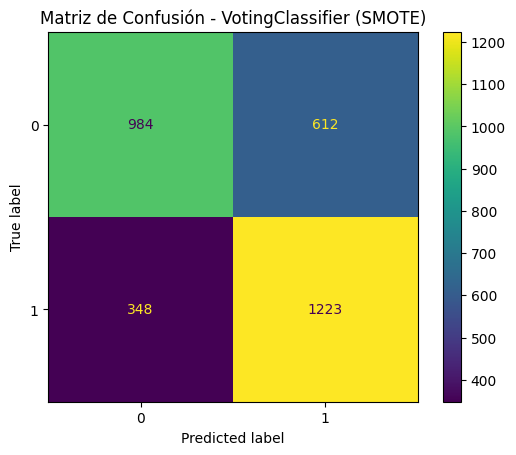

BaggingClassifier (SMOTE)
Accuracy: 0.6924534259551626
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1596
           1       0.69      0.68      0.69      1571

    accuracy                           0.69      3167
   macro avg       0.69      0.69      0.69      3167
weighted avg       0.69      0.69      0.69      3167



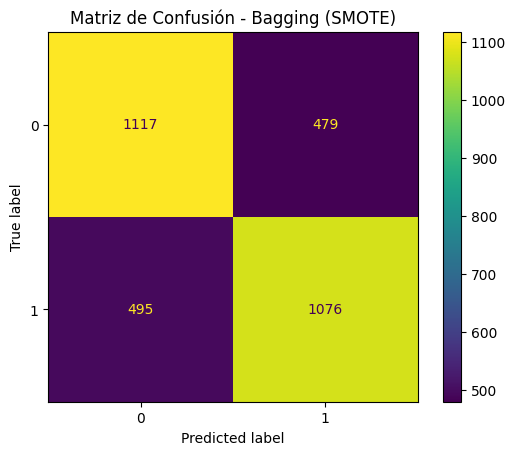

AdaBoostClassifier (SMOTE)
Accuracy: 0.6867698137038206
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1596
           1       0.68      0.69      0.69      1571

    accuracy                           0.69      3167
   macro avg       0.69      0.69      0.69      3167
weighted avg       0.69      0.69      0.69      3167



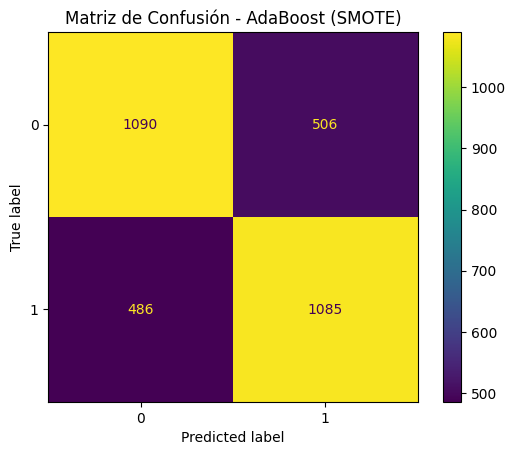

StackingClassifier (SMOTE)
Accuracy: 0.6975055257341333
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      1596
           1       0.68      0.75      0.71      1571

    accuracy                           0.70      3167
   macro avg       0.70      0.70      0.70      3167
weighted avg       0.70      0.70      0.70      3167



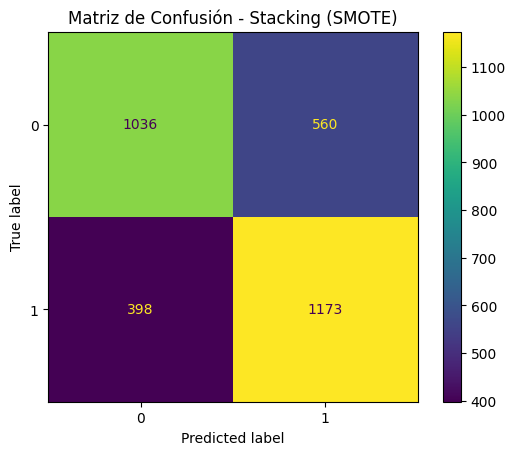

In [ ]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
from imblearn.over_sampling import SMOTE

# Tomar una muestra del 20% de los datos para acelerar el proceso
sample_frac = 0.2  # Usa 20% de los datos
counter_sample = counter.sample(frac=sample_frac, random_state=42)

# Variables predictoras y objetivo
features = [
    'RoundStartingEquipmentValue', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown',
    'PrimaryAssaultRifle', 'PrimarySniperRifle', 'Survived',
    'TeamStartingEquipmentValue', 'MatchKills', 'MatchAssists', 'MatchFlankKills', 'MatchHeadshots'
]
X = counter_sample[features]
y = counter_sample['RoundWinner'].astype(int)

# División de datos (sin escalar aún)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplica SMOTE solo al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Distribución tras SMOTE:", y_train_bal.value_counts())

# 1. Pipeline para VotingClassifier (SMOTE)
voting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('voting', VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=5000, class_weight='balanced')),
            ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
            ('svc', SVC(probability=True, random_state=42, class_weight='balanced'))
        ],
        voting='hard'
    ))
])
voting_pipeline.fit(X_train_bal, y_train_bal)
print("VotingClassifier (SMOTE)")
print("Accuracy:", accuracy_score(y_test, voting_pipeline.predict(X_test)))
print(classification_report(y_test, voting_pipeline.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(voting_pipeline, X_test, y_test)
plt.title("Matriz de Confusión - VotingClassifier (SMOTE)")
plt.show()

# 2. Pipeline para BaggingClassifier (SMOTE)
bagging_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced'),
        n_estimators=50,
        random_state=42
    ))
])
bagging_pipeline.fit(X_train_bal, y_train_bal)
print("BaggingClassifier (SMOTE)")
print("Accuracy:", accuracy_score(y_test, bagging_pipeline.predict(X_test)))
print(classification_report(y_test, bagging_pipeline.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(bagging_pipeline, X_test, y_test)
plt.title("Matriz de Confusión - Bagging (SMOTE)")
plt.show()

# 3. Pipeline para AdaBoost (SMOTE)
boosting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('boosting', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        n_estimators=50,
        random_state=42
    ))
])
boosting_pipeline.fit(X_train_bal, y_train_bal)
print("AdaBoostClassifier (SMOTE)")
print("Accuracy:", accuracy_score(y_test, boosting_pipeline.predict(X_test)))
print(classification_report(y_test, boosting_pipeline.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(boosting_pipeline, X_test, y_test)
plt.title("Matriz de Confusión - AdaBoost (SMOTE)")
plt.show()

# 4. Pipeline para StackingClassifier (SMOTE)
stacking_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stacking', StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=5000, class_weight='balanced')),
            ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
            ('svc', SVC(probability=True, random_state=42, class_weight='balanced'))
        ],
        final_estimator=LogisticRegression(max_iter=5000, class_weight='balanced'),
        passthrough=True
    ))
])
stacking_pipeline.fit(X_train_bal, y_train_bal)
print("StackingClassifier (SMOTE)")
print("Accuracy:", accuracy_score(y_test, stacking_pipeline.predict(X_test)))
print(classification_report(y_test, stacking_pipeline.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(stacking_pipeline, X_test, y_test)
plt.title("Matriz de Confusión - Stacking (SMOTE)")
plt.show()

# Guardar el pipeline completo (

#### Explicación de datos graficados

1. **Voting Classifier**
   * Precisión general: 69%
   * Mejor predicción para victorias (clase 1), con recall de 0.78 y f1-score de 0.72.
   * La precisión para derrotas (clase 0) es más alta (0.74), pero el recall es menor (0.61).
   * El modelo tiende a acertar más cuando predice victorias, pero comete más errores al predecir derrotas.

2. **Bagging Classifier**
   * Precisión general: 69%
   * Desempeño muy equilibrado entre ambas clases (precisión y recall de 0.69-0.70).
   * El modelo comete errores similares en ambas clases, sin un sesgo claro.

3. **AdaBoostClassifier**
   * Precisión general: 69%
   * Precisión y recall muy similares para ambas clases (alrededor de 0.69).
   * El modelo es balanceado, pero no destaca en ninguna clase en particular.

4. **Stacking**
   * Precisión general: 70%
   * Mejor recall para victorias (clase 1, recall 0.75), pero menor para derrotas (clase 0, recall 0.64).
   * El modelo es más efectivo prediciendo victorias, aunque la precisión para derrotas es un poco mayor.

**Conclusión:**  
El desempeño de todos los modelos es muy similar (alrededor de 69-70% de precisión).  
- **VotingClassifier** y **Stacking** tienden a predecir mejor las victorias (clase 1).
- **Bagging** y **AdaBoost** son más balanceados entre ambas clases.
- Para mejorar los resultados, se recomienda ajustar hiperparámetros, probar nuevas variables o técnicas de preprocesamiento.

## Evaluation

## Deployment

In [ ]:
import joblib
import pandas as pd

# 1. Carga el pipeline entrenado
pipeline = joblib.load('pipeline_stacking.pkl')

# 2. Prepara tus datos de entrada (deben tener las mismas columnas/features que usaste para entrenar)
# Ejemplo: un nuevo DataFrame con las mismas columnas que 'features'
nuevos_datos = pd.DataFrame([{
    'RoundStartingEquipmentValue': 25000,
    'RLethalGrenadesThrown': 10,
    'RNonLethalGrenadesThrown': 5,
    'PrimaryAssaultRifle': 1,
    'PrimarySniperRifle': 1,
    'Survived': 1,
    'TeamStartingEquipmentValue': 25000,
    'MatchKills': 40,
    'MatchAssists': 15,
    'MatchFlankKills': 10,
    'MatchHeadshots': 25
}])

# 3. Haz la predicción
prediccion = pipeline.predict(nuevos_datos)
print("Predicción:", prediccion)

Predicción: [0]


In [ ]:
print("Distribución de clases en y_train:")
print(y_train.value_counts())

Distribución de clases en y_train:
RoundWinner
1    6374
0    6290
Name: count, dtype: int64


In [ ]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Distribución tras SMOTE:", y_train_bal.value_counts())

# Entrena el pipeline con X_train_bal, y_train_bal
stacking_pipeline.fit(X_train_bal, y_train_bal)

Distribución tras SMOTE: RoundWinner
0    6374
1    6374
Name: count, dtype: int64


Pipeline(steps=[('scaler', StandardScaler()),
                ('stacking',
                 StackingClassifier(estimators=[('lr',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=5000)),
                                                ('rf',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        random_state=42)),
                                                ('svc',
                                                 SVC(class_weight='balanced',
                                                     probability=True,
                                                     random_state=42))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       max_iter=5000),
                                    passthrough=True))])

##